In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# читаем датасеты
f1 = pd.read_csv("../data/existing_datasets/final_df.csv")
f2 = pd.read_csv("../final_p2.2.csv")

# восстанавливаем названия активностей в первом датасете
f1["activity"] = f1["activity"].replace({1: "peroxidase", 2: "oxidase", 3: "catalase", 4: "laccase"})

# сохраняем фичи, присутствующие во втором датасете
usefull_columns = f2.columns.tolist()
f1 = f1[usefull_columns]
f2 = f2[usefull_columns]

print(f1.shape, f2.shape)

(1130, 43) (2200, 43)


In [3]:
# multi-activity - те, у которых в колонке активность было указано несколько вариантов. Пока не будем разбираться с ними
f2 = f2[((f2["activity"] != "multi-activity") * (~f2["activity"].isna()))]
print(f2.shape)

(2174, 43)


In [4]:
# объединяем датасеты
df = pd.concat([f1, f2], ignore_index=True)
df = df.fillna(0)
df.replace([np.inf, -np.inf], 0, inplace=True)
print("Размер объединённого датасета", df.shape)

# удаляем колонки с значениями, которые не относятся к предсказанию активности
df = df.drop(columns=["id", "Km", "Vmax"])

# исправляем, где ph не число
invalid_values = list(df['ph'][~df['ph'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna()])
df['ph'] = pd.to_numeric(df['ph'].where(lambda ph: ~ph.isin(invalid_values)), errors='coerce')
df = df.fillna(0)

# удаляем дупликаты
df = df.drop_duplicates(ignore_index=True)
print("Размер после удаления дупликатов", df.shape)

Размер объединённого датасета (3304, 43)
Размер после удаления дупликатов (2984, 40)


In [5]:
# сохраняем только частые активности
activity_counts = df['activity'].value_counts()
print(activity_counts)
activities_frequent = activity_counts[activity_counts > 7].index.to_list()
activities_frequent

activity
peroxidase              2489
oxidase                  287
catalase                 132
superoxide dismutase      39
phosphatase               11
esterase                   9
glycosidase                4
reductase                  3
laccase                    3
uricase                    2
dnase                      1
rnase                      1
hydrolase                  1
phosphotriesterase         1
epoxydase                  1
Name: count, dtype: int64


['peroxidase',
 'oxidase',
 'catalase',
 'superoxide dismutase',
 'phosphatase',
 'esterase']

In [6]:
df = df[df["activity"].isin(activities_frequent)]

In [7]:
df["activity"] = df["activity"].apply(lambda x: activities_frequent.index(x) + 1) # нумерация активностей

# Обучение классификатора

In [8]:
RANDOM_STATE = 38
TEST_SIZE = 0.25

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [10]:
# Разделяем на целевой признак и на входные
X = df.drop('activity', axis=1)
y = pd.DataFrame(df['activity'])

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Обучаем как есть

/home/oleg/Programs/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<Axes: title={'center': 'Train'}>

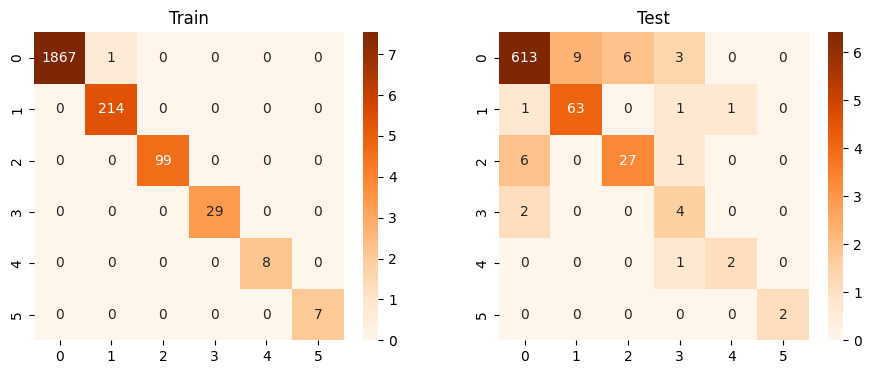

In [11]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Train")
ax2.set_title("Test")
fig.set_size_inches(11, 4)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

Нормальные результаты, посмотрим на важность фич

In [12]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
35,MaxEStateIndex.2,0.236547
11,Cconst,0.105180
31,TPSA2,0.082146
37,MaxPartialCharge.1,0.040695
36,MinPartialCharge.1,0.037725
30,TPSA1,0.037260
2,pot2,0.034830
3,ph,0.033581
29,Complexity1,0.032780
1,IR,0.031295


Самые важные фичи - относящиеся к реакции

# Forward Feature Selection

In [13]:
from sklearn.metrics import classification_report, log_loss, matthews_corrcoef, accuracy_score
from collections import defaultdict
from tqdm.notebook import tqdm

In [14]:
col = X_train.columns.tolist()
used_col = []
col_scores = defaultdict(dict)
for i in tqdm(range(len(X_train.columns))):
    for column in col:
        model = RandomForestClassifier(random_state=RANDOM_STATE)
        model.fit(X_train[used_col + [column,]], y_train.values.reshape(-1, 1).flatten())
        score = matthews_corrcoef(y_test, model.predict(X_test[used_col + [column,]]))
        col_scores[i][column] = score
    best_column, best_score = sorted(list(col_scores[i].items()), key=lambda x: x[1], reverse=True)[0]
    used_col += [best_column,]
    col.remove(best_column)
    print(best_column, best_score)

  0%|          | 0/39 [00:00<?, ?it/s]

MaxEStateIndex.2 0.6580846766283148
TPSA1 0.8060312670826724
temp 0.8307853311942931
ph 0.8593596611784454
TPSA2 0.8736651533174683
Cconst 0.8876107222835165
MaxEStateIndex.1 0.8834747084137702
MinPartialCharge.1 0.8827180745258061
lgCmax 0.8886159795263152
MaxPartialCharge.1 0.8886159795263152
VSA_EState4 0.8834747084137702
X 0.879477747563565
Ccat 0.8737050461817009
pot2 0.8791031935019581
Cmin 0.878336879609781
EState_VSA6 0.8687390698679973
Complexity1 0.8737050461817009
lgCcat 0.8645403886131798
PEOE_VSA7 0.8736790898693639
EState_VSA4 0.8739703932835226
TPSA 0.873940030378927
MinEStateIndex 0.8832433164399565
BCUT2D_CHGLO 0.8790583569992898
dstr 0.8734501075535759
MolWt 0.8694920629370576
MinPartialCharge 0.8743020786217116
SMR_VSA7 0.8736578069027848
PEOE_VSA8 0.8645348606602172
PEOE_VSA9 0.8648888527887588
VSA_EState8 0.8690996614732208
XLogP 0.8548464860581569
BalabanJ 0.868751882803389
lgCmin 0.8600607500761165
Cmax 0.8645754600599451
lgCconst 0.859335558304516
Kappa2 0.85938

In [15]:
reaction_columns = [
    'lgCmin',
    'lgCmax',
    'Cmin',
    'Cmax',
    'lgCconst',
    'Cconst',
    'lgCcat',
    'Ccat',
    'Complexity1',
    'TPSA1',
    'TPSA2',
    'MaxEStateIndex.1',
    'MaxEStateIndex.2',
    'MinPartialCharge.1',
    'MaxPartialCharge.1',
]

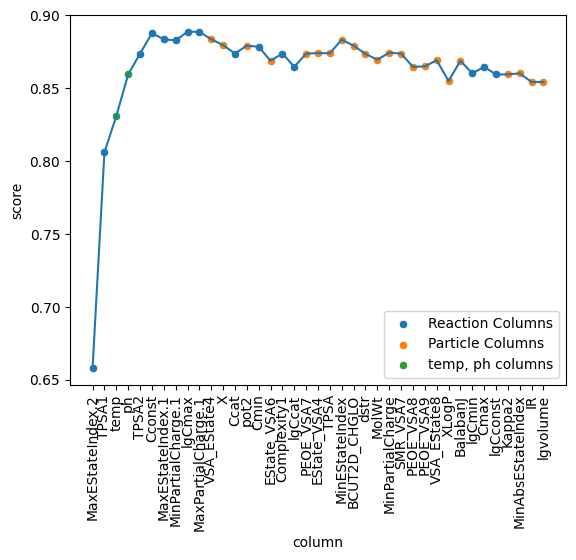

In [16]:
tmp = []
for i in col_scores:
    best_column, best_score = sorted(list(col_scores[i].items()), key=lambda x: x[1], reverse=True)[0]
    tmp.append({"column": best_column, "score": best_score})
tmp = pd.DataFrame(tmp)
sns.lineplot(tmp, x="column", y="score")
sns.scatterplot(tmp[tmp["column"].isin(reaction_columns)], x="column", y="score", label="Reaction Columns")
sns.scatterplot(tmp[~tmp["column"].isin(reaction_columns + ['temp', 'ph'])], x="column", y="score", label="Particle Columns")
sns.scatterplot(tmp[tmp["column"].isin(['temp', 'ph'])], x="column", y="score", label="temp, ph columns")
plt.xticks(rotation=90);

Результаты классификации растут, пока добавляются колонки относящиеся к реакции и начинают падать при добавлениии колонок относящихся к параметрам самой частицы

# Без колонок реакции

In [17]:
df = df.drop(columns=reaction_columns)

In [18]:
df.shape

(2967, 25)

In [19]:
df = df.drop_duplicates(ignore_index=True) # удаление дупликатов после удаления колонок относящихся к реакции
print(df.shape)

(2022, 25)


In [20]:
# Разделяем на целевой признак и на входные
X = df.drop('activity', axis=1)
y = pd.DataFrame(df['activity'])

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

/home/oleg/Programs/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<Axes: title={'center': 'Train'}>

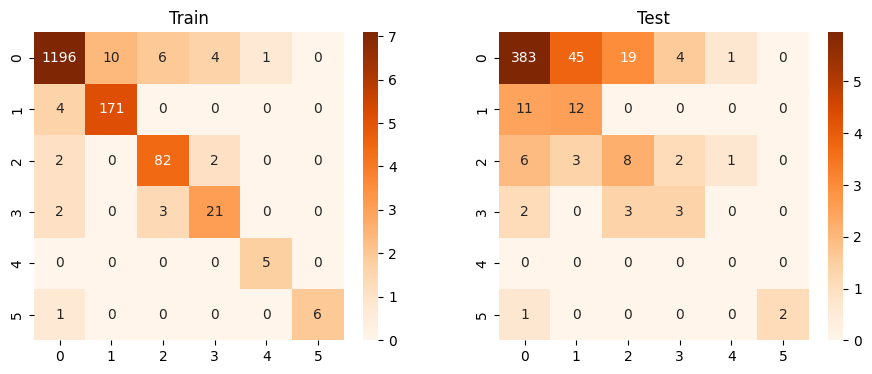

In [21]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Train")
ax2.set_title("Test")
fig.set_size_inches(11, 4)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

Результаты стали хуже

In [22]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
3,ph,0.150852
6,lgvolume,0.146191
2,pot2,0.121151
0,X,0.119899
1,IR,0.113504
4,temp,0.108865
5,dstr,0.027330
21,TPSA,0.019111
22,XLogP,0.018022
12,BalabanJ,0.017019


In [23]:
# Проверка что у одной частицы может быть много активностей
print("Частицы у которых есть несколько активностей:", df.drop("activity", axis=1).duplicated().sum())

Частицы у которых есть несколько активностей: 62


# Просто удалим дублированные

In [24]:
df_one_activity = df[~df.drop("activity", axis=1).duplicated()]
print("Частицы у которых есть несколько активностей:", df_one_activity.drop("activity", axis=1).duplicated().sum())

Частицы у которых есть несколько активностей: 0


In [25]:
df_one_activity.shape

(1960, 25)

In [26]:
df_one_activity = df_one_activity.drop_duplicates(ignore_index=True)
print(df_one_activity.shape)

(1960, 25)


In [27]:
# Разделяем на целевой признак и на входные
X = df_one_activity.drop('activity', axis=1)
y = pd.DataFrame(df_one_activity['activity'])

# Разделяем данные на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

/home/oleg/Programs/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


<Axes: title={'center': 'Train'}>

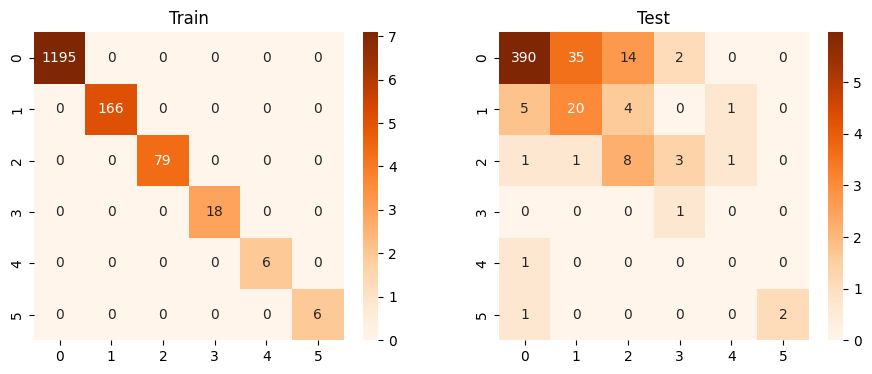

In [28]:
model = RandomForestClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Train")
ax2.set_title("Test")
fig.set_size_inches(11, 4)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

Результаты чуть-чуть стали лучше

In [29]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
3,ph,0.148892
6,lgvolume,0.141755
2,pot2,0.128830
4,temp,0.116091
0,X,0.115978
1,IR,0.102446
5,dstr,0.025739
22,XLogP,0.019180
21,TPSA,0.018675
10,VSA_EState8,0.017626


# Multiclass prediction

In [30]:
one_hot = pd.get_dummies(df['activity'])

In [31]:
df_encoded = pd.concat([df.drop(columns=['activity']), one_hot], axis=1)

In [32]:
grouped = df_encoded.groupby(df_encoded.columns.difference(one_hot.columns.tolist()).tolist(), as_index=False).sum()
grouped

,BCUT2D_CHGLO,BalabanJ,EState_VSA4,EState_VSA6,IR,Kappa2,MinAbsEStateIndex,MinEStateIndex,MinPartialCharge,MolWt,...,lgvolume,ph,pot2,temp,1,2,3,4,5,6
0,-2.590745,0.000002,84.228636,0.000000,1.130000,17.519668,0.428299,0.428299,-0.376668,799.366,...,1.988273,4.0,0.860000,60.0,0,1,0,0,0,0
1,-2.557662,1.897367,0.000000,0.000000,1.084000,1.707240,1.187500,1.187500,-0.264357,140.190,...,4.206747,4.0,-0.103000,25.0,1,0,0,0,0,0
2,-2.557662,1.897367,0.000000,0.000000,1.084000,1.707240,1.187500,1.187500,-0.264357,140.190,...,7.178273,4.0,-0.103000,25.0,1,1,0,0,0,0
3,-2.557662,1.897367,0.000000,0.000000,1.299000,1.707240,1.187500,1.187500,-0.264357,140.190,...,4.644439,9.0,-0.483400,90.0,0,0,1,0,0,0
4,-2.508322,0.793726,7.109798,0.000000,0.300000,37.200135,0.761515,-2.041622,-0.452876,1526.464,...,7.632204,4.0,0.000000,42.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,0.000000,0.000004,61.628008,12.152040,1.400000,12.414398,0.000000,-0.898260,-0.657365,616.499,...,5.602060,4.0,-0.040000,40.0,1,0,0,0,0,0
1956,0.000000,0.000005,12.841643,30.331835,0.832600,14.471101,0.000000,-3.570539,-0.266374,349.492,...,2.535294,4.0,0.279000,35.0,1,0,0,0,0,0
1957,0.000000,0.000005,12.841643,30.331835,1.025600,14.471101,0.000000,-3.570539,-0.266374,349.492,...,2.535294,4.0,0.279000,35.0,1,0,0,0,0,0
1958,0.000000,0.000005,0.000000,24.265468,1.114286,14.883585,0.000000,-4.660983,-0.747944,534.516,...,7.027268,3.0,-0.015429,35.0,1,0,0,0,0,0


In [33]:
X = grouped[df.drop(columns=["activity"]).columns]

In [34]:
grouped.columns

Index([     'BCUT2D_CHGLO',          'BalabanJ',       'EState_VSA4',
             'EState_VSA6',                'IR',            'Kappa2',
       'MinAbsEStateIndex',    'MinEStateIndex',  'MinPartialCharge',
                   'MolWt',         'PEOE_VSA7',         'PEOE_VSA8',
               'PEOE_VSA9',          'SMR_VSA7',              'TPSA',
             'VSA_EState4',       'VSA_EState8',                 'X',
                   'XLogP',              'dstr',          'lgvolume',
                      'ph',              'pot2',              'temp',
                         1,                   2,                   3,
                         4,                   5,                   6],
      dtype='object')

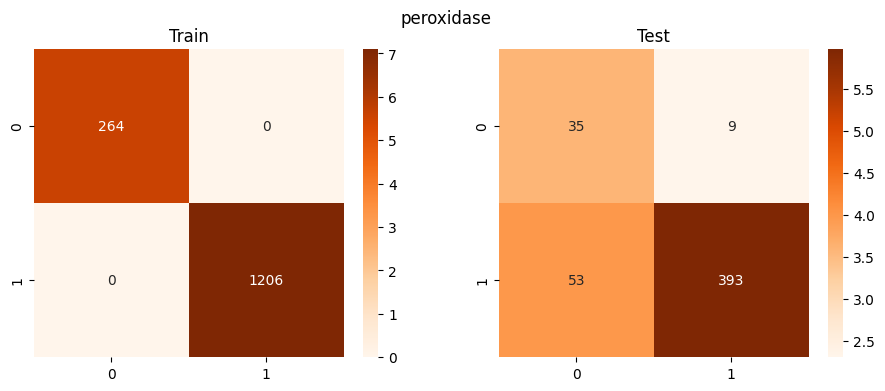

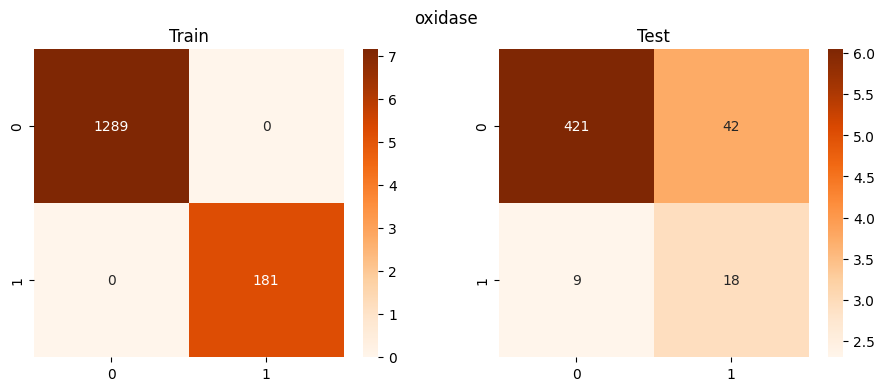

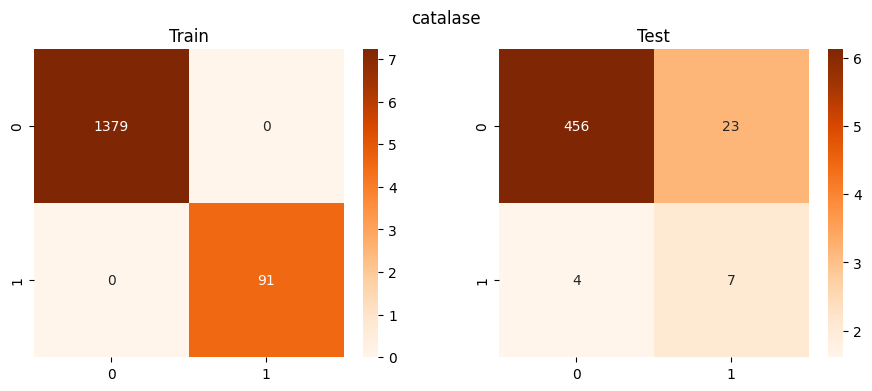

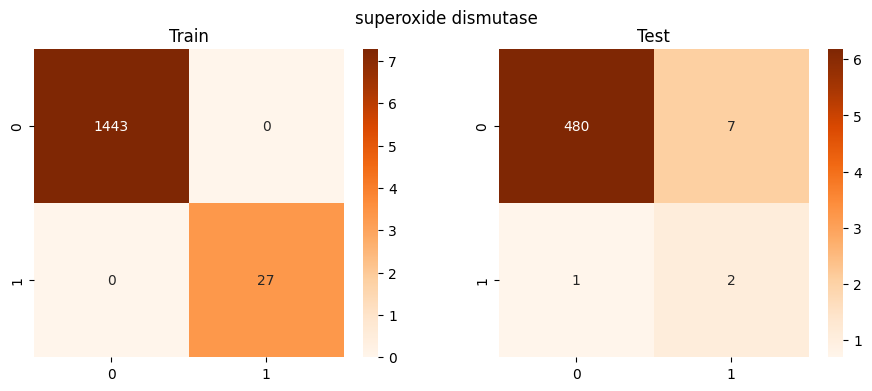

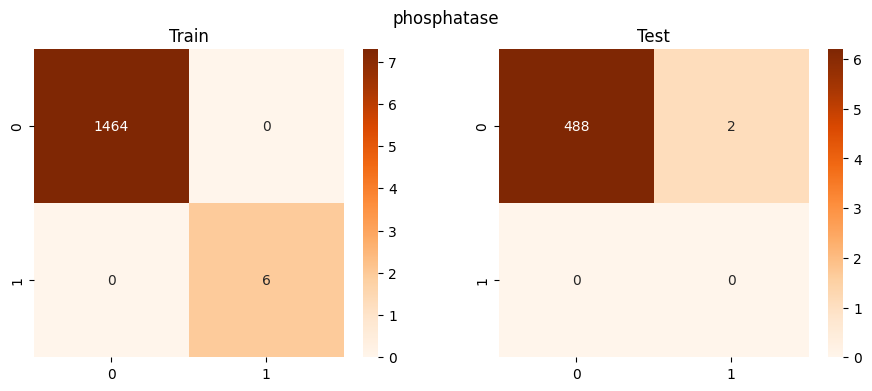

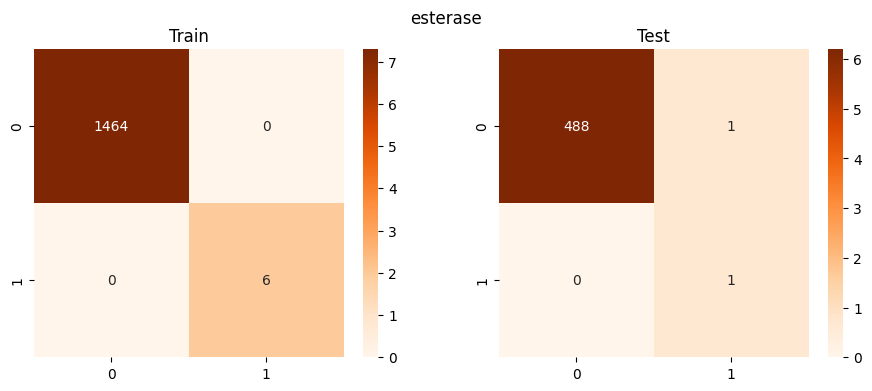

In [35]:
for i in range(1, 7):
    y = grouped[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    model = RandomForestClassifier(random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(activities_frequent[i-1])
    ax1.set_title("Train")
    ax2.set_title("Test")
    fig.set_size_inches(11, 4)
    cm = confusion_matrix(model.predict(X_test), y_test)
    sns.heatmap(
        np.log1p(cm),
        ax=ax2,
        annot=cm,
        fmt='d',
        cmap='Oranges'
    )
    cm = confusion_matrix(model.predict(X_train), y_train)
    sns.heatmap(
        np.log1p(cm),
        ax=ax1,
        annot=cm,
        fmt='d',
        cmap='Oranges'
    )
    plt.show()

Тут вообще сложно оценить, качество классификации

# Различные тесты балансировок и генерации
Тут смотреть пока не чего

## weighted classes

In [36]:
from sklearn.utils.class_weight import compute_class_weight

In [37]:
class_weights = compute_class_weight('balanced', classes=df["activity"].unique(), y=df["activity"])
print(class_weights)
print(dict(enumerate(class_weights, start=1)))

[ 0.20957711  1.39834025  2.78512397  9.36111111 42.125      42.125     ]
{1: np.float64(0.2095771144278607), 2: np.float64(1.3983402489626555), 3: np.float64(2.7851239669421486), 4: np.float64(9.36111111111111), 5: np.float64(42.125), 6: np.float64(42.125)}


In [38]:
model = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight=dict(enumerate(class_weights, start=1))
)
model.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

ValueError: The classes, [0], are not in class_weight

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})
feature_importance.sort_values(by='Importance', ascending=False)

## ROS

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_resampled, y_resampled)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Создание экземпляра SMOTE
smote = SMOTE()

# Применение SMOTE к данным
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
model.fit(X_resampled, y_resampled)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

## ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)

In [ ]:
model.fit(X_resampled, y_resampled)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
cm = confusion_matrix(model.predict(X_test), y_test)
sns.heatmap(
    np.log1p(cm),
    ax=ax2,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)
cm = confusion_matrix(model.predict(X_train), y_train)
sns.heatmap(
    np.log1p(cm),
    ax=ax1,
    annot=cm,
    fmt='d',
    cmap='Oranges'
)

## Feature Selection

## Generation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd
import numpy as np

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return self.fc4(h3)  # output reconstruction

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def get_latent(self, x):
        mu, _ = self.encode(x)
        return mu  # Use mean as latent

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=["activity"]))

input_dim = df.drop(columns=["activity"]).shape[1]
latent_dim = 10
num_classes = df["activity"].nunique()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

features = torch.tensor(df_scaled, dtype=torch.float32)
labels = torch.tensor(df["activity"].values, dtype=torch.long)

dataloader = DataLoader(
    TensorDataset(features, labels),
    batch_size=64,
    shuffle=True)

vae = VAE(input_dim, latent_dim, 20).to(device)
vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(500):
    vae.train()
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        vae_optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        vae_optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, VAE Loss: {(total_loss / len(dataloader.dataset)):.2f}")


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
vae.eval()
latents = []
labels = []
with torch.no_grad():
    for x, l in dataloader:
        x = x.to(device)
        mu, _ = vae.encode(x)  # get mean (latent vector)
        latents.append(mu.cpu())
        labels.append(l)

torch.cat(latents, dim=0).shape, torch.cat(labels, dim=0).shape  # shape: [num_samples, latent_dim]


In [ ]:
hidden = np.array(torch.cat(latents, dim=0).tolist())

In [ ]:
s = pca.fit_transform(hidden)

In [ ]:
plt.scatter(s.T[0], s.T[1], c=torch.cat(labels, dim=0))